## Check goodness of fit (GEV vs. Gumbel) on full 50-year period
* Need to mount Greenplanet to get original 30-year periods


In [1]:
import scipy as scipy
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import multiprocessing
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os.path
import xarray as xr 
import pickle 
import copy

from joblib import Parallel, delayed
from scipy.stats import genextreme as gev
from scipy.stats import gumbel_r as gumbel
from netCDF4 import Dataset


In [2]:
# --- Load in data --- #

#Load first 20 years (new period)
[annMaxFull,lat,lon] = pickle.load(open('ExtendAnnMax_FULL.pkl', 'rb' ))
#annMaxFull = copy.deepcopy(annMaxCtrl)  #Forgot to change variable name when file created, so copying/renaming here
[annMaxCtrl,lat,lon] = pickle.load(open('ExtendAnnMax_CTRL.pkl', 'rb' ))

#Load last 30 years (original)
matData   = sio.loadmat('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/control_outflw.mat')
maxYearly = matData['maxYearly_full']

fullData   = sio.loadmat('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/full_outflw.mat')
fullYearly = fullData['maxYearly_full']


# Takes about 38.5 minutes

In [3]:
print('Shape of new arrays: ',np.shape(annMaxFull))
print('Shape of old arrays: ', np.shape(maxYearly))
print('Using transpose to reverse dimensions of new arrays.')

#Shapes are in reverse order, so re-ordering new arrays to be [lon x lat x time]
annMaxFull = np.transpose(annMaxFull)
annMaxCtrl = np.transpose(annMaxCtrl)
print('New shape of new arrays:',np.shape(annMaxFull))


Shape of new arrays:  (20, 720, 1440)
Shape of old arrays:  (1440, 720, 30)
Using transpose to reverse dimensions of new arrays.
New shape of new arrays: (1440, 720, 20)


In [4]:
# --- Combine both sets of data to get a full fifty years --- #
extendFull = np.full([len(lon),len(lat),50],np.nan)
extendCtrl = np.full([len(lon),len(lat),50],np.nan)

extendFull[:,:,0:30]  = fullYearly
extendFull[:,:,30:50] = annMaxFull

extendCtrl[:,:,0:30]  = maxYearly
extendCtrl[:,:,30:50] = annMaxCtrl


In [13]:
print(np.nanmean(extendCtrl[:,:,36]))
print(np.nanmean(extendCtrl[:,:,20]))

0.050827090894449936
0.048958385047464394


### Compute the Probability Plot Correlation Coefficient at every point to determine goodness of fit 

In [14]:
# --- Define function to compute PPCC at each point --- #

def computePPCC(recArray,i):
    
    if np.remainder(i,100)==0:
        print(i) 
        
    ppccGEVtemp    = np.full([len(lat)],np.nan)
    ppccGumbelTemp = np.full([len(lat)],np.nan)
    
    for j in range(len(lat)):   

        #print(j)
        rec     = recArray[j,:]

        # Check for NaN 
        validCount = np.count_nonzero(~np.isnan(rec))
              
        if validCount>5: 
            #print("Starting to compute...")
            
            #Fit GEV
            gev_fit = gev.fit(rec)
            K_gev = gev_fit[0]  #shape
            M_gev = gev_fit[1]  #location
            S_gev = gev_fit[2]  #scale
            #Compute PPCC
            qs    = np.sort(rec)
            n     = len(qs)
            p     = (np.arange(n)+1)/(n+1)
            qhat  = gev.ppf(p,K_gev,M_gev,S_gev)
            ppccGEVtemp[j] = np.corrcoef(qs,qhat)[0][1]
            #ppccGEVtemp[j] = corrPearson(qs,qhat)[0]
    
            #Fit Gumbel
            gumbel_fit = gumbel.fit(rec)
            M_gumb = gumbel_fit[0]
            S_gumb = gumbel_fit[1]
            #Compute PPCC
            qhatNew = gumbel.ppf(p,M_gumb,S_gumb)
            ppccGumbelTemp[j] = np.corrcoef(qs,qhatNew)[0][1]
            #ppccGumbelTemp[j] = corrPearson(qs,qhatNew)[0]
            
    ppccGEV = ppccGEVtemp
    ppccGumbel = ppccGumbelTemp
    
    return ppccGEV, ppccGumbel



In [17]:
#Define empty arrays
ppccGEV    = np.full([len(lon),len(lat)],np.nan)
ppccGumbel = np.full([len(lon),len(lat)],np.nan)

rec     = extendCtrl

Tbig = Parallel(n_jobs=5)(delayed(computePPCC)(rec[i,:,:],i) for i in range(len(lon)))

for i in range(len(Tbig)):
    ppccGEV[i,:]    = Tbig[i][0]
    ppccGumbel[i,:] = Tbig[i][1]


#With njobs=5, takes ~48.5 minutes
#With njobs = 10, takes ~29.5 minutes
#With njobs = 15, takes ~21.5 minutees 

0


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: inv

100
200
300
400
500
600
700
1000
1200
800
1100
1300
1400
900


In [21]:
print('Gumbel:',np.nanmean(np.nanmean(ppccGumbel)))
print('GEV: ',np.nanmean(np.nanmean(ppccGEV)))

Gumbel: 0.960363155972088
GEV:  0.8770362204647305


In [22]:
# Define colors 
gev_col = ppccGEV
gumbel_col = ppccGumbel

colorsGEV = np.full([len(lon),len(lat)],np.nan)
colorsGEV[np.where(gev_col<=0.80)] = 1
colorsGEV[np.where((gev_col>0.80)  & (gev_col<=0.90))]  = 2
colorsGEV[np.where((gev_col>0.90)  & (gev_col<=0.95))]  = 3
colorsGEV[np.where((gev_col>0.95)  & (gev_col<=0.97))]  = 4
colorsGEV[np.where((gev_col>0.97)  & (gev_col<=0.98))]  = 5
colorsGEV[np.where((gev_col>0.98)  & (gev_col<=0.99))]  = 6
colorsGEV[np.where(gev_col>0.99)]   = 7

colorsGumbel = np.full([len(lon),len(lat)],np.nan)
colorsGumbel[np.where(gumbel_col<=0.80)] = 1
colorsGumbel[np.where((gumbel_col>0.80)  & (gumbel_col<=0.90))]  = 2
colorsGumbel[np.where((gumbel_col>0.90)  & (gumbel_col<=0.95))]  = 3
colorsGumbel[np.where((gumbel_col>0.95)  & (gumbel_col<=0.97))]  = 4
colorsGumbel[np.where((gumbel_col>0.97)  & (gumbel_col<=0.98))]  = 5
colorsGumbel[np.where((gumbel_col>0.98)  & (gumbel_col<=0.99))]  = 6
colorsGumbel[np.where(gumbel_col>0.99)]   = 7


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encou

In [23]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

### Create a list of RGB tuples
colorsList = [(255,0,0),(255,(127),0),(0,255,0),(0,255,255),(51,153,255),(0,0,255),(1,1,153)] # This example uses the 8-bit RGB

#colors = [(15,19,135), (9,61,240), (35,93,209), (43,156,222),(90,193,253), 
#           (221,238,247), (246,246,22),(246,186,22),(246,126,22), (246,67,22),(255,24,16)] # This example uses the 8-bit RGB
my_cmap = make_cmap(colorsList, bit=True)

<bound method Figure.show of <Figure size 1152x864 with 3 Axes>>

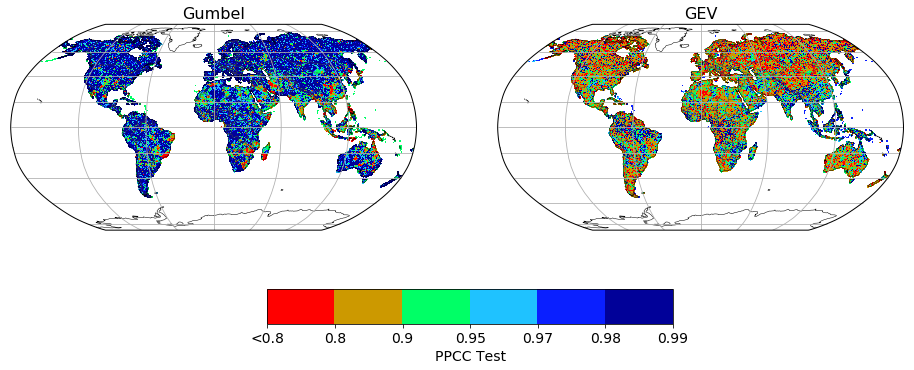

In [24]:
# --- Plot PPCC maps --- #

fig, ax_array = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)

bounds = [1,2,3,4,5,6,7]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

# Subplot 1: Gumbel PPCC #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon,lat,np.transpose(colorsGumbel),norm=norm,cmap=my_cmap,vmin=1,vmax=7,transform=ccrs.PlateCarree())
#Other figure options 
ax1.set_title('Gumbel')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Subplot 2: GEV PPCC #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon,lat,np.transpose(colorsGEV),norm=norm,cmap=my_cmap,vmin=1,vmax=7,transform=ccrs.PlateCarree())
#Other figure options 
ax2.set_title('GEV')
ax2.title.set_fontsize(16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Colorbar 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0+0.15, ax_position.width, 0.04])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('PPCC Test',fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(['<0.8','0.8','0.9','0.95','0.97','0.98', '0.99'],fontsize=14)  # vertically oriented colorbar

fig.show


## Does this do anything to the map of return period? 

In [47]:
def computeGumbel(recArray,recFullArr,i):
    
    if np.remainder(i,100)==0:
        print(i) 
        
    TfullInt = np.full([len(lat)],np.nan)
    
    for j in range(len(lat)):   

        #print(j)
        rec     = recArray[j,:]
        recFull = recFullArr[j,:]

       
        # Check for NaN 
        validCount = np.count_nonzero(~np.isnan(rec))
              
        if validCount>5: 
            #print("Starting to compute...")
            
            gumbel_fit = gumbel.fit(rec)
            M = gumbel_fit[0]
            S = gumbel_fit[1]
    
            #Compute discharge of 100-year flood 
            R100 = gumbel.ppf((1-(1/retPeriod)),loc=M,scale=S)
            # Imagine we have the PDF for the gumbel fit of flood magnitude
            # R100 is the flood magnitude corresopnding to 99% probability i.e.
            # Inverting the CDF at 0.99
            # i.e. 1-CDF = 0.01 (definition of the 100 year flood)
            # Analogous to tinv (0.99,dof) in matlab inversion of t-distribution.
            # So if rec --> 100*rec, R100 --> 100*R100
    
            #Compute fit for CO2 experiments
            gumbelFull = gumbel.fit(recFull)
    
            cdfFull = gumbel.cdf(R100,*gumbelFull)    #Compute CDF at the point of R100 
            # Let's suppose the PDF shifts to the right. 
            # Then the same magnitude flood from R100 would be more likely to occur
            # I.e more of the tail is to the right of R100
            # So CDF of the new fitted distribution evaluated at the old R100 will be < 0.99 
            # And 1-CDF is the boost in the tail to the right of R100.
            # It might be more like 4/100 
            # The inverse of that (100/4) says the 100 year flood happens every 25 years.
    
            TfullInt[j] = 1/(1-cdfFull)    #Return Period 
            
    Tfull = TfullInt
    
    return Tfull

In [43]:
def computeGEV(recArray,recFullArr,i):
    
    if np.remainder(i,100)==0:
        print(i) 
    
    #print(len(lat))
    
    TfullInt = np.full([len(lat)],np.nan)
    
    for j in range(len(lat)):   

        #print(j)
        rec     = recArray[j,:]
        recFull = recFullArr[j,:]
       
        # Check for NaN 
        validCount = np.count_nonzero(~np.isnan(rec))
              
        if validCount>5: 
            #print("Starting to compute...")
            
            gev_fit = gev.fit(rec)
            M = gev_fit[0]
            S = gev_fit[1]
    
            #Compute discharge of 100-year flood 
            R100 = gev.ppf((1-(1/retPeriod)),gev_fit[0],loc=M,scale=S)
    
            #Compute fit for CO2 experiments
            gevFull = gev.fit(recFull)
    
            cdfFull = gev.cdf(R100,*gevFull)    #Compute CDF at the point of R100 
    
            TfullInt[j] = 1/(1-cdfFull)    #Return Period 

            
    Tfull = TfullInt
    
    return Tfull

In [51]:
# -- Compute Gumbel based flood return period -- #

Tfull = np.full([len(lon),len(lat)],np.nan)

rec     = maxYearly
recFull = fullYearly

retPeriod = 100.0  #Return period

Tbig_orig = Parallel(n_jobs=2)(delayed(computeGumbel)(rec[i,:,:],recFull[i,:,:],i) for i in range(len(lon)))

for i in range(len(Tbig)):
    Tfull[i,:] = Tbig[i][0]


0


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars


100


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars


200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [53]:
np.nanmean(Tbig_orig)

inf

In [54]:
# -- Compute Gumbel based flood return period -- #

Tfull_extend = np.full([len(lon),len(lat)],np.nan)

rec     = extendCtrl
recFull = extendFull

retPeriod = 100.0  #Return period

Tbig_ext = Parallel(n_jobs=2)(delayed(computeGumbel)(rec[i,:,:],recFull[i,:,:],i) for i in range(len(lon)))

for i in range(len(Tbig)):
    Tfull_extend[i,:] = Tbig[i][0]



0


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars


100


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars


200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


Make flood return period maps...

In [9]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

### Create a list of RGB tuples
colorsList = [(27,30,72), (62,86,170), (81,144,208), (104,200,220),(166,227,221), 
           (221,238,247), (248,247,100),(250,203,0),(249,81,1), (246,80,149),(242,30,15)] # This example uses the 8-bit RGB

#colors = [(15,19,135), (9,61,240), (35,93,209), (43,156,222),(90,193,253), 
#           (221,238,247), (246,246,22),(246,186,22),(246,126,22), (246,67,22),(255,24,16)] # This example uses the 8-bit RGB
my_cmap = make_cmap(colorsList, bit=True)

In [56]:
np.nanmean(Tfull)

/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


nan

1036800

In [60]:
# Define array of colors for maps

Tfull_col       = np.asarray(Tbig_orig)
TfullExtend_col = np.asarray(Tbig_ext)

colorsFull = np.full([len(lon),len(lat)],np.nan)
colorsFull[np.where((Tfull_col>=2)  & (Tfull_col<=5))]     = 1
colorsFull[np.where((Tfull_col>5)   & (Tfull_col<=25))]    = 2
colorsFull[np.where((Tfull_col>25)  & (Tfull_col<=50))]    = 3
colorsFull[np.where((Tfull_col>50)  & (Tfull_col<=75))]    = 4
colorsFull[np.where((Tfull_col>75)  & (Tfull_col<=95))]    = 5
colorsFull[np.where((Tfull_col>95)  & (Tfull_col<=105))]   = 6
colorsFull[np.where((Tfull_col>105) & (Tfull_col<=125))]   = 7
colorsFull[np.where((Tfull_col>125) & (Tfull_col<=250))]   = 8
colorsFull[np.where((Tfull_col>250) & (Tfull_col<=500))]   = 9
colorsFull[np.where((Tfull_col>500) & (Tfull_col<=1000))]  = 10
colorsFull[np.where(Tfull_col>1000)]                       = 11

colorsFullExtend = np.full([len(lon),len(lat)],np.nan)
colorsFullExtend[np.where((TfullExtend_col>=2)  & (TfullExtend_col<=5))]     = 1
colorsFullExtend[np.where((TfullExtend_col>5)   & (TfullExtend_col<=25))]    = 2
colorsFullExtend[np.where((TfullExtend_col>25)  & (TfullExtend_col<=50))]    = 3
colorsFullExtend[np.where((TfullExtend_col>50)  & (TfullExtend_col<=75))]    = 4
colorsFullExtend[np.where((TfullExtend_col>75)  & (TfullExtend_col<=95))]    = 5
colorsFullExtend[np.where((TfullExtend_col>95)  & (TfullExtend_col<=105))]   = 6
colorsFullExtend[np.where((TfullExtend_col>105) & (TfullExtend_col<=125))]   = 7
colorsFullExtend[np.where((TfullExtend_col>125) & (TfullExtend_col<=250))]   = 8
colorsFullExtend[np.where((TfullExtend_col>250) & (TfullExtend_col<=500))]   = 9
colorsFullExtend[np.where((TfullExtend_col>500) & (TfullExtend_col<=1000))]  = 10
colorsFullExtend[np.where(TfullExtend_col>1000)]                       = 11


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: Ru

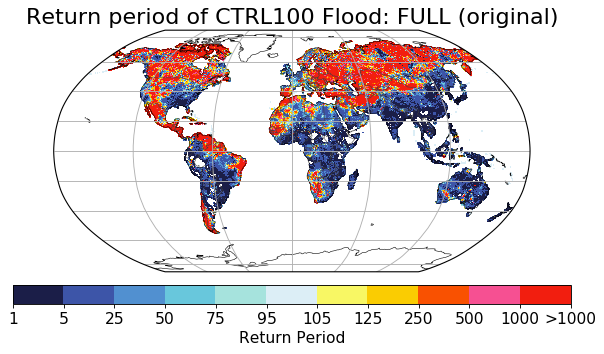

In [61]:
## PLOT TFULL RETURN PERIOD

fig=plt.figure(figsize=(9, 4), dpi=80, facecolor='w', edgecolor='k')
my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig.set_size_inches(9,4)

## --- Create Plot ---
colorsFullT = np.transpose(colorsFull)
contour_plot = ax.pcolormesh(lon,lat,colorsFullT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('Return period of CTRL100 Flood: FULL (original)')
ax.title.set_fontsize(20)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



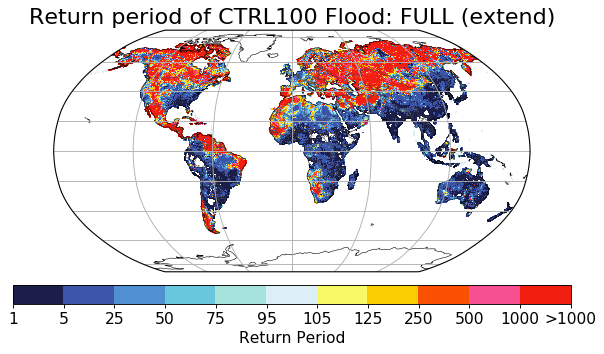

In [63]:
## PLOT TFULL RETURN PERIOD

fig=plt.figure(figsize=(9, 4), dpi=80, facecolor='w', edgecolor='k')
my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig.set_size_inches(9,4)

## --- Create Plot ---
colorsFullT = np.transpose(colorsFullExtend)
contour_plot = ax.pcolormesh(lon,lat,colorsFullT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('Return period of CTRL100 Flood: FULL (extend)')
ax.title.set_fontsize(20)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




## Do same for GEV

In [5]:
def computeGEV(ctrl,full,i):
    
    if np.remainder(i,100)==0:
        print(i)
    
    # Define empty arrays to save data into
    Tfull = np.full([len(lat)],np.nan)

    j=0
    while j<len(lat):
        
        # Compute GEV fit for CTRL and compute discharge of "retPeriod"-year flood
        rec = ctrl[j,:]
        
        # Check for NaN 
        validCount = np.count_nonzero(~np.isnan(rec))
        
        if validCount>5:
        
            gev_fit = gev.fit(rec)
        
            K = gev_fit[0]
            M = gev_fit[1]
            S = gev_fit[2]
        
            R100=gev.ppf((1-(1/retPeriod)),K,loc=M,scale=S)
        
            # Compute return period of that magnitude flood in 4xCO2 experiments 
            recFull = full[j]
         
            gevFull = gev.fit(recFull)   #Fit GEV to get parameters in each case     

            cdfFull = gev.cdf(R100,*gevFull)    #Compute CDF at the point of R100 
        
            Tfull[j] = 1/(1-cdfFull)    #Return Period 
            
        j = j+1
    
    Tfull_ret = Tfull
    
    return Tfull_ret
    

In [6]:
# -- Compute GEV based flood return period -- #

Tfull = np.full([len(lon),len(lat)],np.nan)

rec     = maxYearly
recFull = fullYearly

retPeriod = 100.0  #Return period

Tbig_orig = Parallel(n_jobs=2)(delayed(computeGEV)(rec[i,:,:],recFull[i,:,:],i) for i in range(len(lon)))



0


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [11]:
# -- Compute GEV based flood return period -- #

Tfull_extend = np.full([len(lon),len(lat)],np.nan)

rec     = extendCtrl
recFull = extendFull

retPeriod = 100.0  #Return period

Tbig_ext = Parallel(n_jobs=2)(delayed(computeGEV)(rec[i,:,:],recFull[i,:,:],i) for i in range(len(lon)))


0


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [12]:
# Define array of colors for maps

#Tfull_colGEV       = np.asarray(Tbig_orig)
TfullExtend_colGEV = np.asarray(Tbig_ext)

# colorsFull = np.full([len(lon),len(lat)],np.nan)
# colorsFull[np.where((Tfull_colGEV>=2)  & (Tfull_colGEV<=5))]     = 1
# colorsFull[np.where((Tfull_colGEV>5)   & (Tfull_colGEV<=25))]    = 2
# colorsFull[np.where((Tfull_colGEV>25)  & (Tfull_colGEV<=50))]    = 3
# colorsFull[np.where((Tfull_colGEV>50)  & (Tfull_colGEV<=75))]    = 4
# colorsFull[np.where((Tfull_colGEV>75)  & (Tfull_colGEV<=95))]    = 5
# colorsFull[np.where((Tfull_colGEV>95)  & (Tfull_colGEV<=105))]   = 6
# colorsFull[np.where((Tfull_colGEV>105) & (Tfull_colGEV<=125))]   = 7
# colorsFull[np.where((Tfull_colGEV>125) & (Tfull_colGEV<=250))]   = 8
# colorsFull[np.where((Tfull_colGEV>250) & (Tfull_colGEV<=500))]   = 9
# colorsFull[np.where((Tfull_colGEV>500) & (Tfull_colGEV<=1000))]  = 10
# colorsFull[np.where(Tfull_colGEV>1000)]                       = 11

colorsFullExtend = np.full([len(lon),len(lat)],np.nan)
colorsFullExtend[np.where((TfullExtend_colGEV>=2)  & (TfullExtend_colGEV<=5))]     = 1
colorsFullExtend[np.where((TfullExtend_colGEV>5)   & (TfullExtend_colGEV<=25))]    = 2
colorsFullExtend[np.where((TfullExtend_colGEV>25)  & (TfullExtend_colGEV<=50))]    = 3
colorsFullExtend[np.where((TfullExtend_colGEV>50)  & (TfullExtend_colGEV<=75))]    = 4
colorsFullExtend[np.where((TfullExtend_colGEV>75)  & (TfullExtend_colGEV<=95))]    = 5
colorsFullExtend[np.where((TfullExtend_colGEV>95)  & (TfullExtend_colGEV<=105))]   = 6
colorsFullExtend[np.where((TfullExtend_colGEV>105) & (TfullExtend_colGEV<=125))]   = 7
colorsFullExtend[np.where((TfullExtend_colGEV>125) & (TfullExtend_colGEV<=250))]   = 8
colorsFullExtend[np.where((TfullExtend_colGEV>250) & (TfullExtend_colGEV<=500))]   = 9
colorsFullExtend[np.where((TfullExtend_colGEV>500) & (TfullExtend_colGEV<=1000))]  = 10
colorsFullExtend[np.where(TfullExtend_colGEV>1000)]                       = 11



/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less_equal
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/meganfowler/anaconda3/lib/

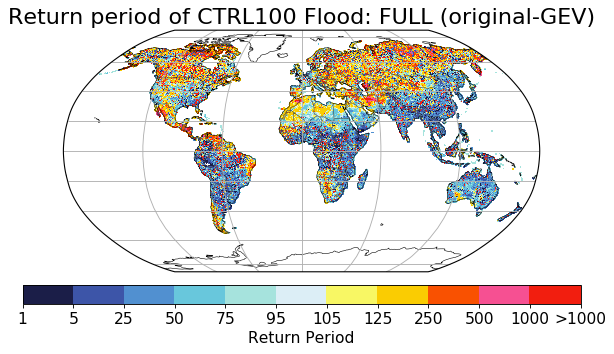

In [10]:
## PLOT TFULL RETURN PERIOD

fig=plt.figure(figsize=(9, 4), dpi=80, facecolor='w', edgecolor='k')
my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig.set_size_inches(9,4)

## --- Create Plot ---
colorsFullT = np.transpose(colorsFull)
contour_plot = ax.pcolormesh(lon,lat,colorsFullT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('Return period of CTRL100 Flood: FULL (original-GEV)')
ax.title.set_fontsize(20)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




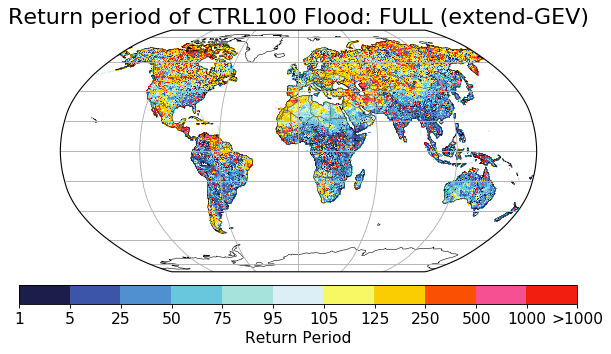

In [13]:
## PLOT TFULL RETURN PERIOD

fig=plt.figure(figsize=(9, 4), dpi=80, facecolor='w', edgecolor='k')
my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig.set_size_inches(9,4)

## --- Create Plot ---
colorsFullT = np.transpose(colorsFullExtend)
contour_plot = ax.pcolormesh(lon,lat,colorsFullT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('Return period of CTRL100 Flood: FULL (extend-GEV)')
ax.title.set_fontsize(20)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



